In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn

### 图

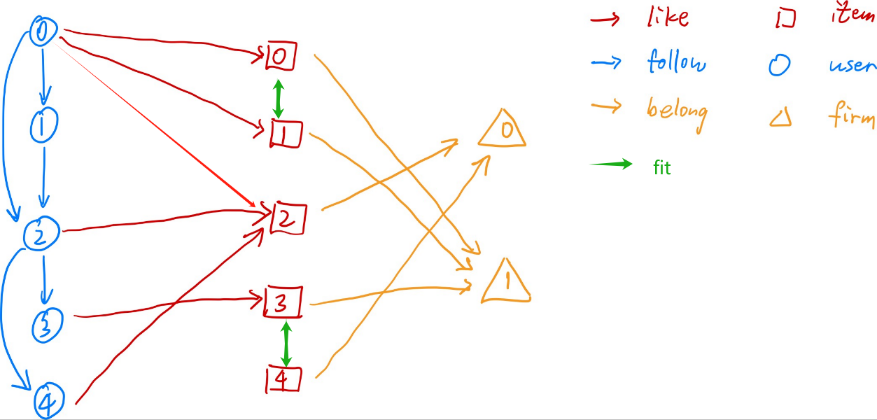

In [55]:
user_feat = torch.FloatTensor([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
item_feat = torch.FloatTensor([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]])
firm_feat = torch.FloatTensor([[0, 0, 0], [1, 1, 1]])

follow_feat = torch.ones(5)  # [,1]
like_feat = torch.arange(6)  # [,1]
belong_feat = torch.eye(5)  # [,5]

follow_edge = [
    [0, 0, 1, 2, 2],
    [1, 2, 2, 3, 4],
]
like_edge = [
    [0, 0, 0, 2, 3, 4],
    [0, 1, 2, 2, 3, 2],
]
belong_edge = [
    [0, 1, 2, 3, 4],
    [1, 1, 0, 1, 0],
]
fit_edge = [[0, 1, 3, 4], [1, 0, 4, 3]]


firm_label = torch.LongTensor([0, 1])
item_label = torch.LongTensor([1, 1, 0, 1, 0])
user_label = torch.LongTensor([3, 0, 1, 1, 1])

In [56]:
hg = dgl.heterograph(
    {
        ("item", "belong", "firm"): (belong_edge[0], belong_edge[1]),
        ("user", "like", "item"): (like_edge[0], like_edge[1]),
        ("item", "fit", "item"): (fit_edge[0], fit_edge[1]),
        ("user", "follow", "user"): (follow_edge[0], follow_edge[1]),
    }
)


hg.nodes["user"].data["feat"] = user_feat
hg.nodes["item"].data["feat"] = item_feat
hg.nodes["firm"].data["feat"] = firm_feat
hg.nodes["user"].data["label"] = user_label
hg.nodes["item"].data["label"] = item_label
hg.nodes["firm"].data["label"] = firm_label

hg.edges["follow"].data["feat"] = follow_feat
hg.edges["like"].data["feat"] = like_feat
hg.edges["belong"].data["feat"] = belong_feat

# add self loop需要指定边，可以选择fill_data方法，sum mean ...
hg = hg.add_self_loop(etype=("user", "follow", "user"), fill_data="sum")
# hg = hg.add_self_loop(etype=("user", "follow", "user"), fill_data="sum")

mods针对不同边类型定义模型
```python
 mods : dict[str, nn.Module]
        Modules associated with every edge types. The forward function of each
        module must have a `DGLGraph` object as the first argument, and
        its second argument is either a tensor object representing the node
        features or a pair of tensor object representing the source and destination
        node features.
```

### 使用现成的层

In [61]:
# weight=False就是简单相加
mods = {
    ("user", "follow", "user"): dgl.nn.GraphConv(
        3,
        1,
        norm="none",
        bias=False,
        weight=False,
        allow_zero_in_degree=True,
    ),
    ("user", "like", "item"): dgl.nn.GraphConv(
        3, 2, norm="none", bias=False, weight=False, allow_zero_in_degree=True
    ),
    ("item", "fit", "item"): dgl.nn.GraphConv(
        3, 2, norm="none", bias=False, weight=False, allow_zero_in_degree=True
    ),
    ("item", "belong", "firm"): dgl.nn.GraphConv(
        3, 3, norm="none", bias=False, weight=False, allow_zero_in_degree=True
    ),
}

根据边关系来传递消息

In [62]:
outputs = {nty: [] for nty in hg.dsttypes}

with torch.no_grad():
    for relation in hg.canonical_etypes:
        srctype, etype, dsttype = relation
        rel_mod = mods[relation]
        print("in", relation)

        out = rel_mod(hg[relation], hg.nodes[srctype].data["feat"])
        print(out)
        outputs[dsttype] = out

in ('item', 'belong', 'firm')
tensor([[6., 6., 6.],
        [4., 4., 4.]])
in ('item', 'fit', 'item')
tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [4., 4., 4.],
        [3., 3., 3.]])
in ('user', 'follow', 'user')
tensor([[0., 0., 0.],
        [1., 1., 1.],
        [3., 3., 3.],
        [5., 5., 5.],
        [6., 6., 6.]])
in ('user', 'like', 'item')
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [6., 6., 6.],
        [3., 3., 3.],
        [0., 0., 0.]])


### 自定义层、fn

In [63]:
etypes = ["follow", "like", "fit", "belong"]

In [64]:
in_feats = 3
out_feats = 4

In [65]:
# 定义每个关系类型的权重
weight = nn.ModuleDict(
    {name: nn.Linear(in_feats, out_feats, bias=False) for name in etypes}
)

nn.init.ones_(weight.belong.weight)
nn.init.ones_(weight.like.weight)
nn.init.ones_(weight.follow.weight)
nn.init.ones_(weight.fit.weight)


print(weight)

ModuleDict(
  (follow): Linear(in_features=3, out_features=4, bias=False)
  (like): Linear(in_features=3, out_features=4, bias=False)
  (fit): Linear(in_features=3, out_features=4, bias=False)
  (belong): Linear(in_features=3, out_features=4, bias=False)
)


In [132]:
funcs = {}
for c_etype in hg.canonical_etypes:
    srctype, etype, dsttype = c_etype
    Wh = weight[etype](hg.nodes[srctype].data["feat"])
    # 把它存在图中用来做消息传递
    # hg.nodes[srctype].data['Wh_%s' % etype] = Wh
    hg.srcnodes[srctype].data["Wh_%s" % etype] = Wh
    funcs[etype] = (fn.copy_u("Wh_%s" % etype, "m"), fn.sum("m", "h"))

hg.multi_update_all(funcs, "stack")
# sum是整合方式，这个整合方式可以是 sum、 min、 max、 mean 和 stack 中的一个

srcdata
```python
user Wh_follow
 tensor([[ 0.,  0.,  0.,  0.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [ 9.,  9.,  9.,  9.],
        [12., 12., 12., 12.]])
user Wh_like
 tensor([[ 0.,  0.,  0.,  0.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [ 9.,  9.,  9.,  9.],
        [12., 12., 12., 12.]])
item Wh_fit
 tensor([[ 0.,  0.,  0.,  0.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [ 9.,  9.,  9.,  9.],
        [12., 12., 12., 12.]])
```

muti_update_all 使用 sum 整合
```python
user    torch.Size([5, 4])
tensor([[ 0.,  0.,  0.,  0.],
        [ 3.,  3.,  3.,  3.],
        [ 9.,  9.,  9.,  9.],
        [15., 15., 15., 15.],
        [18., 18., 18., 18.]])
item    torch.Size([5, 4])
tensor([[ 3.,  3.,  3.,  3.],
        [ 0.,  0.,  0.,  0.],
        [18., 18., 18., 18.],
        [21., 21., 21., 21.],
        [ 9.,  9.,  9.,  9.]])
firm    torch.Size([2, 4])
tensor([[18., 18., 18., 18.],
        [12., 12., 12., 12.]])
```

muti_update_all 使用 stack 整合, item 能接收两种节点的信息，五个节点，shape是[5,2,4]，.sum(dim=1)相当于sum整合
```python
user    torch.Size([5, 1, 4])
tensor([[[ 0.,  0.,  0.,  0.]],

        [[ 3.,  3.,  3.,  3.]],

        [[ 9.,  9.,  9.,  9.]],

        [[15., 15., 15., 15.]],

        [[18., 18., 18., 18.]]])
item    torch.Size([5, 2, 4])
tensor([[[ 3.,  3.,  3.,  3.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [18., 18., 18., 18.]],

        [[12., 12., 12., 12.],
         [ 9.,  9.,  9.,  9.]],

        [[ 9.,  9.,  9.,  9.],
         [ 0.,  0.,  0.,  0.]]])
firm    torch.Size([2, 1, 4])
tensor([[[18., 18., 18., 18.]],

        [[12., 12., 12., 12.]]])
```

In [133]:
with torch.no_grad():
    for i in ["user", "item", "firm"]:
        print(i, "  ", hg.ndata["h"][i].shape)
        print(hg.ndata["h"][i].detach())

user    torch.Size([5, 1, 4])
tensor([[[ 0.,  0.,  0.,  0.]],

        [[ 3.,  3.,  3.,  3.]],

        [[ 9.,  9.,  9.,  9.]],

        [[15., 15., 15., 15.]],

        [[18., 18., 18., 18.]]])
item    torch.Size([5, 2, 4])
tensor([[[ 3.,  3.,  3.,  3.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [18., 18., 18., 18.]],

        [[12., 12., 12., 12.],
         [ 9.,  9.,  9.,  9.]],

        [[ 9.,  9.,  9.,  9.],
         [ 0.,  0.,  0.,  0.]]])
firm    torch.Size([2, 1, 4])
tensor([[[18., 18., 18., 18.]],

        [[12., 12., 12., 12.]]])


### 自定义message、reduce

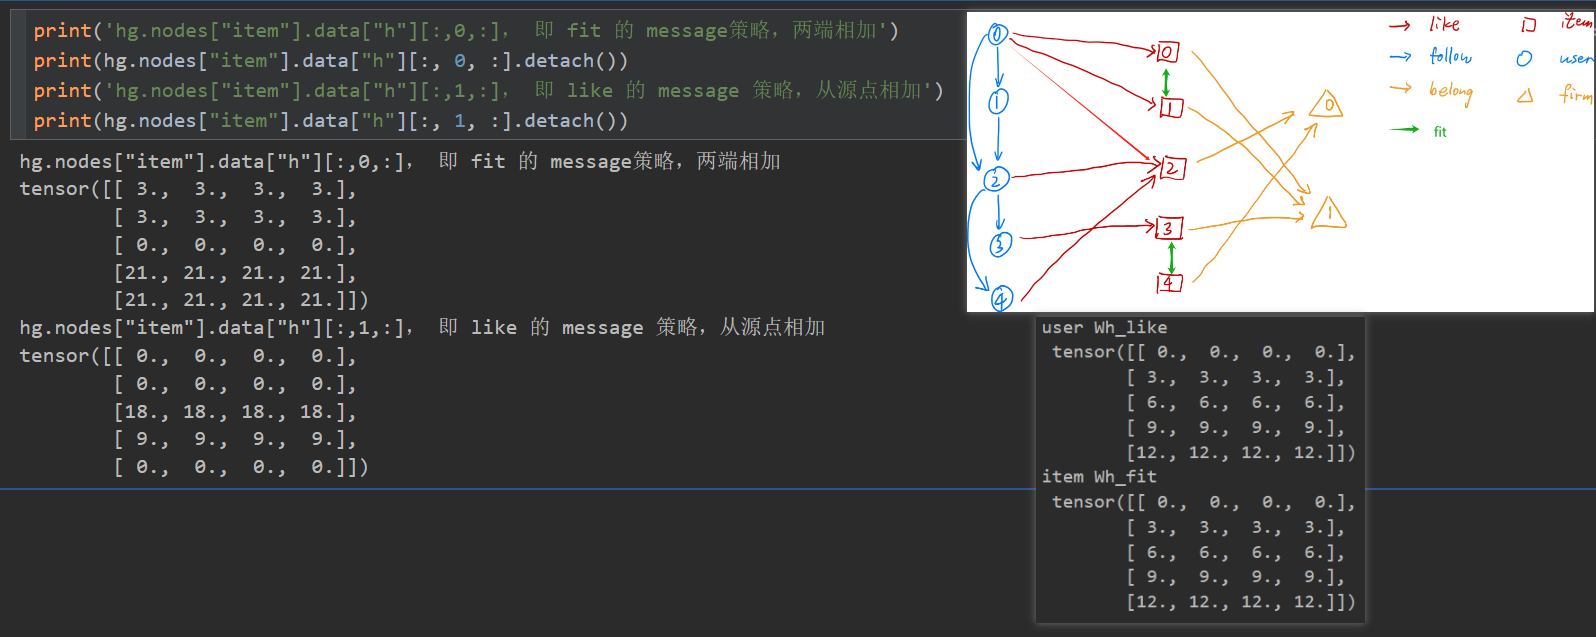

In [146]:
def myMessage(edges: dgl.udf.EdgeBatch):
    srctype, etype, dsttype = edges.canonical_etype
    if etype == "belong":
        # print("belong")
        return {"m": edges.src["Wh_%s" % etype]}
    if etype == "like":
        # print("like")
        return {"m": edges.src["Wh_%s" % etype]}
    if etype == "follow":
        # print("follow")
        src = edges.src["Wh_%s" % etype]
        dst = edges.dst["Wh_%s" % etype]
        # h=src+dst
        return {"m": src + dst}
    if etype == "fit":
        # print("fit")
        src = edges.src["Wh_%s" % etype]
        dst = edges.dst["Wh_%s" % etype]
        # h=src+dst
        return {"m": src + dst}


funcs = {}
for c_etype in hg.canonical_etypes:
    srctype, etype, dsttype = c_etype
    Wh = weight[etype](hg.nodes[srctype].data["feat"])
    # 把它存在图中用来做消息传递
    # hg.nodes[srctype].data["Wh_%s" % etype] = Wh
    hg.srcnodes[srctype].data["Wh_%s" % etype] = Wh

    # funcs[etype] = (fn.copy_u("Wh_%s" % etype, "m"), fn.sum("m", "h"))
    funcs[etype] = (myMessage, fn.sum("m", "h"))

hg.multi_update_all(funcs, "stack")

In [176]:
print("user Wh_like\n", hg.nodes["user"].data["Wh_like"].detach())
print("item Wh_fit\n", hg.nodes["item"].data["Wh_fit"].detach())

user Wh_like
 tensor([[ 0.,  0.,  0.,  0.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [ 9.,  9.,  9.,  9.],
        [12., 12., 12., 12.]])
item Wh_fit
 tensor([[ 0.,  0.,  0.,  0.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [ 9.,  9.,  9.,  9.],
        [12., 12., 12., 12.]])


In [178]:
print('hg.nodes["item"].data["h"][:,0,:]， 即 fit 的 message策略，两端相加')
print(hg.nodes["item"].data["h"][:, 0, :].detach())
print('hg.nodes["item"].data["h"][:,1,:]， 即 like 的 message 策略，从源点相加')
print(hg.nodes["item"].data["h"][:, 1, :].detach())

hg.nodes["item"].data["h"][:,0,:]， 即 fit 的 message策略，两端相加
tensor([[ 3.,  3.,  3.,  3.],
        [ 3.,  3.,  3.,  3.],
        [ 0.,  0.,  0.,  0.],
        [21., 21., 21., 21.],
        [21., 21., 21., 21.]])
hg.nodes["item"].data["h"][:,1,:]， 即 like 的 message 策略，从源点相加
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [18., 18., 18., 18.],
        [ 9.,  9.,  9.,  9.],
        [ 0.,  0.,  0.,  0.]])
